In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import gym
import matplotlib.pyplot as plt

In [3]:
NUM_RUNS = 10
EPSILON = 1      # placeholder value - you should implement your own exploration schedule

In [8]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,64, 64, 2])
    target_net = DQN([4, 64, 64, 2])
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=0.7)
    memory = ReplayBuffer(1000)

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) > 30:
                transitions = memory.sample(1)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 30 == 0: 
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

In [14]:
import csv

def calculate_average_returns_and_deviation(results):
    """
    Calculate the average returns and deviation of a DQN model.
    This 
    
    Args:
        results: the results of running the DQN across 10 runs. 

    Returns:
        float: The average reward over the last 50 episodes.
    """
    results = torch.tensor(results)
    means = results.float().mean(0)[:-50].mean()
    stds = results.float().std(0)[:-50].mean()
    
    return float(means), float(stds)


def fitness_score(mean_reward, std_dev, penalty_factor=1.0):
    """
    Calculate the fitness score as the mean reward penalized by a factor of the standard deviation.

    Args:
        mean_reward (float): The average reward over the last 50 episodes.
        std_dev (float): The standard deviation of the rewards over the last 50 episodes.
        penalty_factor (float): The factor by which to multiply the standard deviation before subtracting from the mean.

    Returns:
        float: The calculated fitness score.
    """
    return mean_reward - penalty_factor * std_dev


def run_individual(individual):
    # tweak this to run for the variation in hyperparameters
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(individual["num_runs"]):
        # print(f"Starting run {run+1} of {individual['num_runs']}")
        policy_net = DQN(individual["network_architecture"]) 
        target_net = DQN(individual["network_architecture"])
        update_target(target_net, policy_net)
        target_net.eval()
    
        optimizer = optim.SGD(policy_net.parameters(), lr=individual["learning_rate"])
        memory = ReplayBuffer(individual["replay_buffer_size"])
    
        episode_durations = []
        
        epsilon_start = individual["epsilon_start"]
        epsilon_end = individual["epsilon_end"]
        epsilon_decay = individual["epsilon_decay"]
        epsilon = epsilon_start
    
        for i_episode in range(300):
            #if (i_episode+1) % 50 == 0:
            #    print("episode ", i_episode+1, "/", 300)
    
            # Epsilon Decay
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                math.exp(-1. * i_episode / epsilon_decay)
    
            observation, info = env.reset()
            state = torch.tensor(observation).float()
    
            done = False
            terminated = False
            t = 0
            while not (done or terminated):
    
                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)
    
                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()
    
                memory.push([state, action, next_state, reward, torch.tensor([done])])
    
                # Move to the next state
                state = next_state
    
                # Perform one step of the optimization (on the policy network)
                if len(memory.buffer) >= individual["batch_size"]:
                    transitions = memory.sample(individual["batch_size"])
                    state_batch, action_batch, next_state_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, next_state_batch, dones)
    
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
                
            # Update the target network, copying all weights and biases in DQN
            if i_episode % individual["update_frequency"] == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete', str(individual))
    return runs_results

def initialize_csv(csv_filename="hyperparam.csv"):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Define your CSV columns here
        writer.writerow(['Hyperparameters', 'Reward Mean', 'Standard Deviation'])

def write_results_to_csv(individual, reward_mean, std_mean, csv_filename="hyperparam.csv"):
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([str(individual), reward_mean, std_mean])

def plot_chart(runs_results, filename):
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    
    plt.plot(torch.arange(300), means)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
    plt.savefig(filename)
    plt.show()
    plt.close()

def convert_hyperparams_to_filename(config):
    config_key = tuple([config[key] if type(config[key]) != list else tuple(config[key]) for key in config.keys()])
    return "_".join(map(str, config_key)) + ".png"

def run_sim(hyperparameters):
    run_res = run_individual(hyperparameters)
    mean_return, mean_std = calculate_average_returns_and_deviation(run_res)
    plot_chart(run_res, filename=convert_hyperparams_to_filename(hyperparameters))
    write_results_to_csv(hyperparameters, mean_return, mean_std)

In [13]:
initialize_csv()
used_params = set()

Complete {'num_runs': 10, 'epsilon_decay': 0.03, 'learning_rate': 0.15, 'replay_buffer_size': 15000, 'batch_size': 32, 'update_frequency': 20, 'loss_function': 'MSE', 'epsilon_start': 0.5, 'epsilon_end': 0.01, 'network_architecture': (4, 8, 8, 2)}


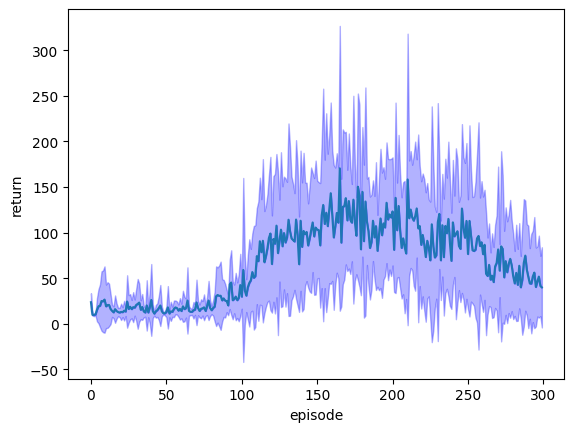

Complete {'num_runs': 10, 'epsilon_decay': 0.03, 'learning_rate': 0.15, 'replay_buffer_size': 15000, 'batch_size': 32, 'update_frequency': 20, 'loss_function': 'MSE', 'epsilon_start': 1, 'epsilon_end': 0.01, 'network_architecture': (4, 8, 8, 2)}


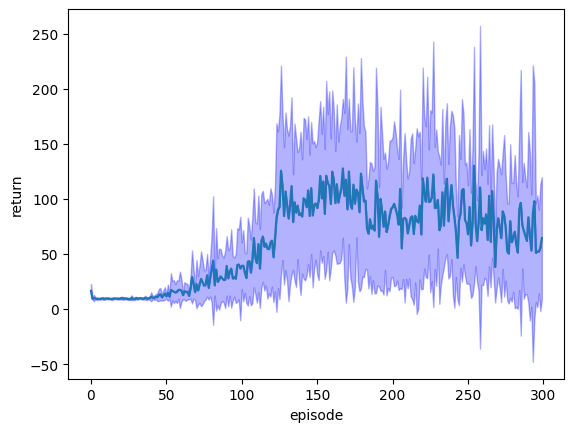

Complete {'num_runs': 10, 'epsilon_decay': 0.03, 'learning_rate': 0.15, 'replay_buffer_size': 15000, 'batch_size': 32, 'update_frequency': 20, 'loss_function': 'MSE', 'epsilon_start': 0.7, 'epsilon_end': 0.01, 'network_architecture': (4, 8, 8, 2)}


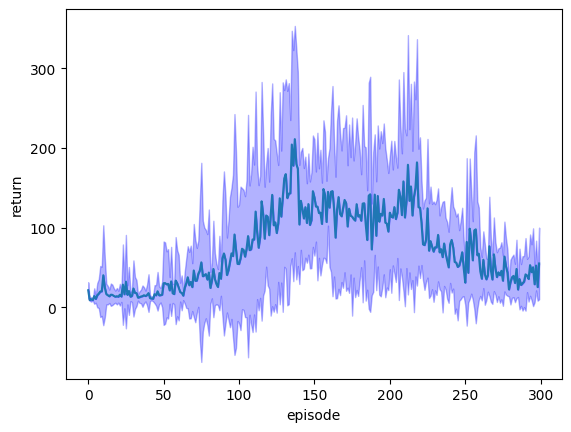

Complete {'num_runs': 10, 'epsilon_decay': 0.03, 'learning_rate': 0.15, 'replay_buffer_size': 15000, 'batch_size': 32, 'update_frequency': 20, 'loss_function': 'MSE', 'epsilon_start': 0.2, 'epsilon_end': 0.01, 'network_architecture': (4, 8, 8, 2)}


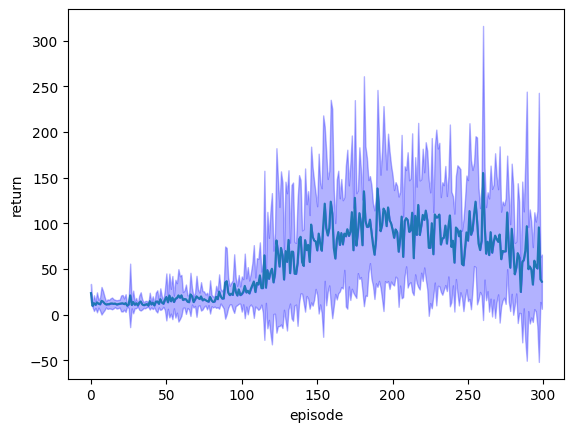

Complete {'num_runs': 10, 'epsilon_decay': 0.03, 'learning_rate': 0.15, 'replay_buffer_size': 15000, 'batch_size': 32, 'update_frequency': 20, 'loss_function': 'MSE', 'epsilon_start': 0.8, 'epsilon_end': 0.01, 'network_architecture': (4, 8, 8, 2)}


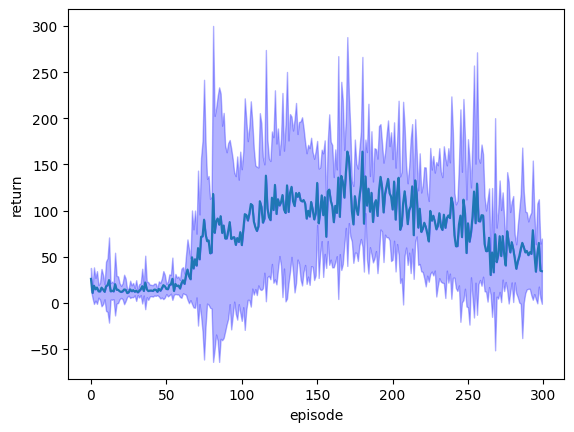

In [39]:
import random 

hyper_parameter_space = {
    "num_runs": [10], # fixed at 10 for the time being...
    "epsilon_decay": [0.03], # Higher the slower episilon decreases, lower it decreaess more 
    "learning_rate": [0.15], # smaller learning helps model converge steadily
    "replay_buffer_size": [15000],
    "batch_size": [32],
    "update_frequency": [20],
    "loss_function": ["MSE"],
    "network_architecture": [[4, 8, 8, 2]],
    "epsilon_start": [0.7],
    "epsilon_end":[0.01]
}


def generate_random_configuration(hyper_parameter_space):
    configuration = {
        'num_runs': random.choice(hyper_parameter_space['num_runs']),
        'epsilon_decay': random.choice(hyper_parameter_space['epsilon_decay']),
        'learning_rate': random.choice(hyper_parameter_space['learning_rate']),
        'replay_buffer_size': random.choice(hyper_parameter_space['replay_buffer_size']),
        'batch_size': random.choice(hyper_parameter_space['batch_size']),
        'update_frequency': random.choice(hyper_parameter_space['update_frequency']),
        'loss_function': random.choice(hyper_parameter_space['loss_function']),
        'epsilon_start': random.choice(hyper_parameter_space['epsilon_start']),
        'epsilon_end': random.choice(hyper_parameter_space['epsilon_end']),
        'network_architecture': tuple(random.choice(hyper_parameter_space['network_architecture']))  # Convert to tuple
    }
    return configuration


NUM_TRYS_FOR_UNIQUE_COMBO = 10000
# Randomise the configs and show on a graph. 
for i in range(NUM_TRYS_FOR_UNIQUE_COMBO):
    configuration = generate_random_configuration(hyper_parameter_space)
    config_key = tuple([configuration[key] if type(configuration[key]) != list else tuple(configuration[key]) for key in configuration])

    if config_key in used_params:
        continue

    used_params.add(config_key)

    #print("Training with:", configuration)

    # Add your training and evaluation code here
    run_sim(configuration)
    # plot_chart(runs_results, "_".join(map(str, config_key)) + ".png")

    # Insert a break condition as needed


In [ ]:

# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(300), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()